# Lab 1: Feature Engineering Challenge
XBUS-511: Diagnostics for More Informed Machine Learning

In this exercise, we will explore a few datasets that exhibit outliers, collinearity, and other issues, and see what we can do to prepare the data for machine learning.


## Imports

In [1]:
import os
import zipfile
import warnings
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from yellowbrick.features import Rank1D, Rank2D, ParallelCoordinates

warnings.filterwarnings("ignore")

## Data fetching helper function

In [2]:
def fetch_data(url, fname):
    """
    Helper method to retrieve data.
    """
    response = requests.get(url)
    outpath  = os.path.abspath(fname)
    with open(outpath, "wb") as f:
        f.write(response.content)
    
    return outpath

# Regressing Facebook Post Comments 


Thanks to [this team](https://github.com/Wall-eSociety/CommentVolumeML) for figuring out the labels for this dataset!

In [3]:
# Make the directory where we'll store data
FIXTURES = os.path.join("..", "fixtures")
if not os.path.exists(FIXTURES):
    os.makedirs(FIXTURES)

In [4]:
# Fetch and unzip the data

URL = "https://tinyurl.com/y2ks5fjf"
ZIPPED_FILES = "facebook_data.zip"
UNZIPPED_FILES = "facebook_data"

zipped_data = fetch_data(
    URL, 
    os.path.join(FIXTURES, ZIPPED_FILES)
)

with zipfile.ZipFile(
    os.path.join(FIXTURES, ZIPPED_FILES), "r"
) as zfiles:
    zfiles.extractall(
        os.path.join(FIXTURES, UNZIPPED_FILES)
    )

In [5]:
fb_df = pd.read_csv(
    os.path.join(
        FIXTURES, 
        UNZIPPED_FILES, 
        "Dataset", 
        "Training", 
        "Features_Variant_2.csv"
    ),
    header=None
)
columns = [
    "likes", "views", "returns", "category", "derived_1", 
    "derived_2", "derived_3", "derived_4", "derived_5",
    "derived_6", "derived_7", "derived_8", "derived_9",
    "derived_10", "derived_11", "derived_12", "derived_13",
    "derived_14", "derived_15", "derived_16", "derived_17",
    "derived_18", "derived_19", "derived_20", "derived_21",
    "derived_22", "derived_23", "derived_24", "derived_25",
    "cc_1", "cc_2", "cc_3", "cc_4", "cc_5", "base_time",
    "length", "shares", "status", "h_local", "sunday_post",
    "monday_post", "tuesday_post", "wednesday_post",
    "thursday_post", "friday_post", "saturday_post",
    "sunday_base", "monday_base", "tuesday_base",
    "wednesday_base", "thursday_base", "friday_base",
    "saturday_base", "target"
]
fb_df.columns = columns

In [6]:
fb_df.describe()

,likes,views,returns,category,derived_1,derived_2,derived_3,derived_4,derived_5,derived_6,...,friday_post,saturday_post,sunday_base,monday_base,tuesday_base,wednesday_base,thursday_base,friday_base,saturday_base,target
count,8.131200e+04,81312.000000,8.131200e+04,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,...,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000,81312.000000
mean,1.313921e+06,4667.704336,4.475377e+04,24.255633,0.707190,464.665781,55.728933,35.392255,67.588653,0.143361,...,0.146153,0.136954,0.141049,0.133400,0.138417,0.145477,0.155180,0.144997,0.141480,7.190611
std,6.804951e+06,20561.261034,1.109279e+05,19.949156,12.169748,520.925523,85.243275,67.043844,82.836764,7.819979,...,0.353262,0.343801,0.348075,0.340008,0.345340,0.352583,0.362078,0.352100,0.348518,36.049374
min,3.600000e+01,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.673400e+04,0.000000,6.980000e+02,9.000000,0.000000,47.000000,5.190751,2.000000,8.032349,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.929110e+05,0.000000,7.045000e+03,18.000000,0.000000,251.000000,22.794183,13.000000,32.565168,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.204214e+06,99.000000,5.026400e+04,32.000000,0.000000,717.000000,71.791489,42.000000,102.060861,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,4.869723e+08,186370.000000,6.089942e+06,106.000000,1311.000000,2438.000000,1693.500000,1693.500000,743.091650,1311.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1966.000000


In [7]:
# Divide the data into features and target
target = "target"

X = fb_df.loc[:, fb_df.columns != target].values
y = fb_df[target].values

## Explore Distributions of Features

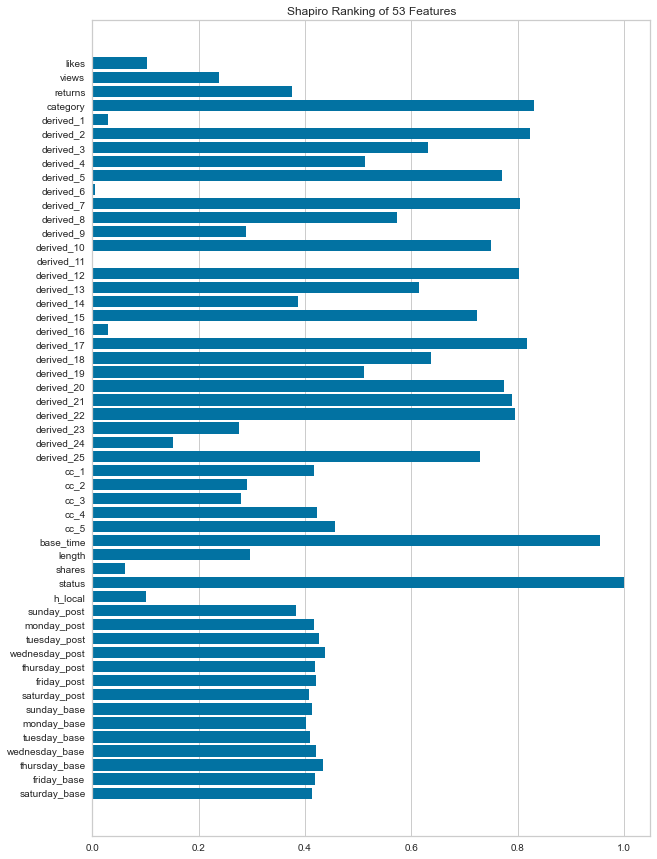

<AxesSubplot:title={'center':'Shapiro Ranking of 53 Features'}>

In [8]:
features = [column for column in columns if column != "target"]

visualizer = Rank1D(
    algorithm="shapiro",
    features=features,
    size=(720, 1080)
)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

What do you notice about the above? How might it impact your feature engineering or model selection process?

## Are There Outliers?

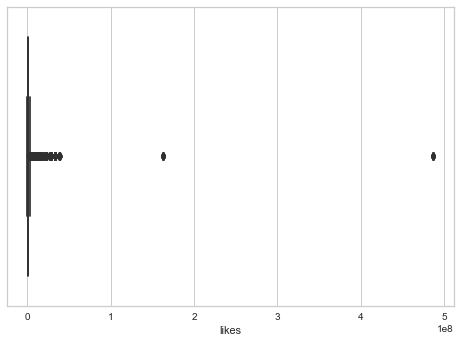

In [9]:
like_count = sns.boxplot(x=fb_df["likes"])

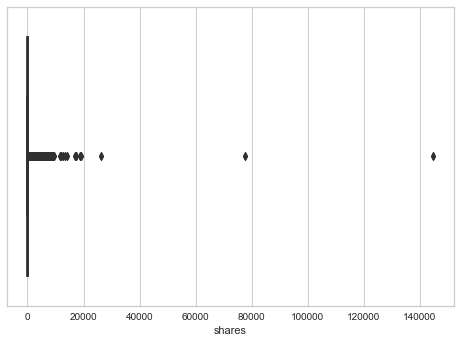

In [10]:
share_count = sns.boxplot(x=fb_df["shares"])

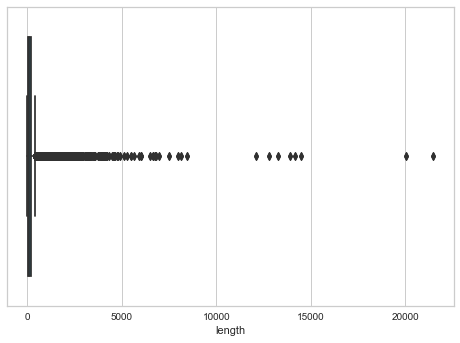

In [11]:
post_length = sns.boxplot(x=fb_df["length"])

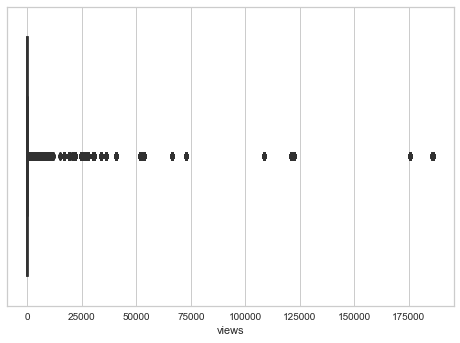

In [12]:
view_count = sns.boxplot(x=fb_df["views"])

## Is there Collinearity?

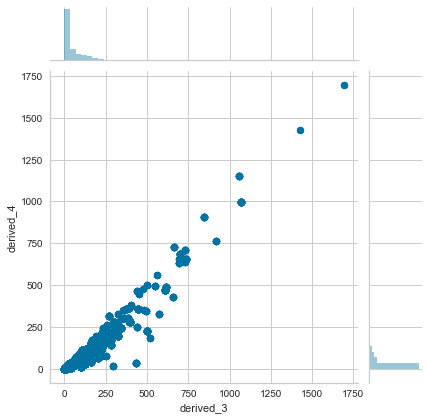

In [13]:
sns.jointplot(data=fb_df, x="derived_3", y="derived_4")

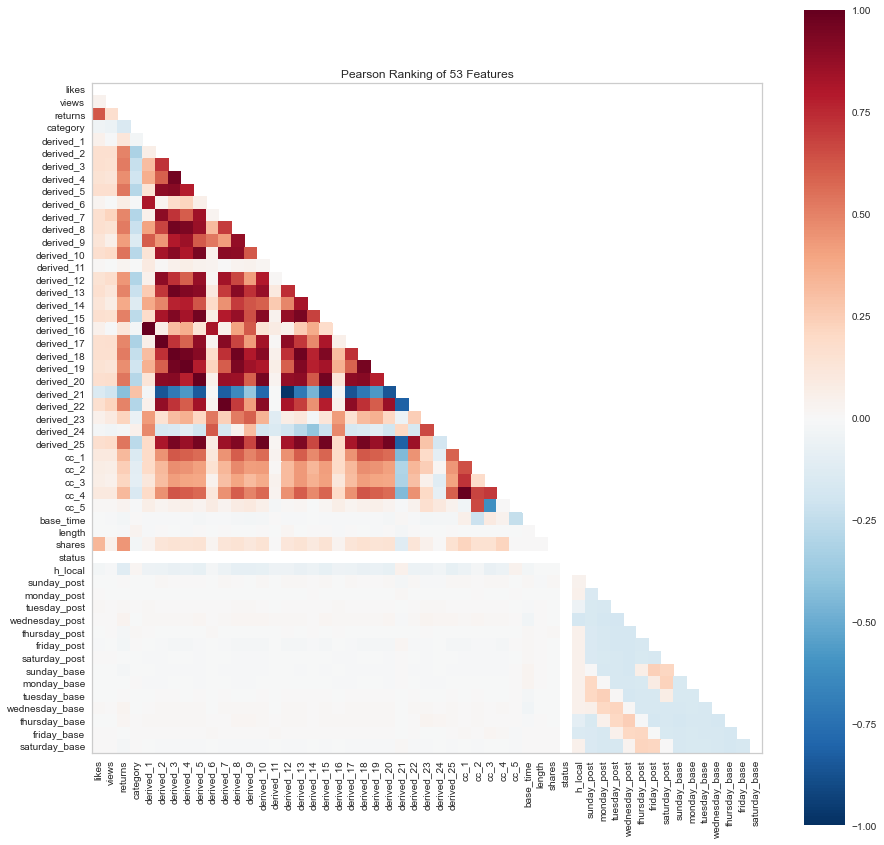

<AxesSubplot:title={'center':'Pearson Ranking of 53 Features'}>

In [14]:
visualizer = Rank2D(
    algorithm="pearson", 
    features=features,
    size=(1080, 1080)
)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

What do you notice about the above? How might it impact your feature engineering or model selection process?

## Is there Correlation?

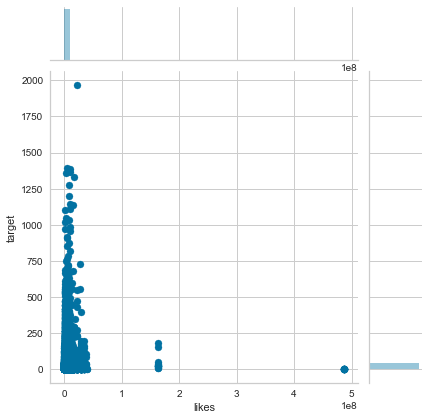

In [15]:
# Do any of the features correlate with the target?
# Hint - change "likes" below to other features
sns.jointplot(data=fb_df, x="likes", y="target")

## Build a Regression Model

The goal is to build a model that can predict the number of comments a Facebook post would receive, given the features available about the post.

# Categorizing Credit Card Fraud

In [16]:
# Fetch the data
URL = "https://datahub.io/machine-learning/creditcard/r/creditcard.csv"
FNAME = "creditcard.csv"
data = fetch_data(URL, os.path.join(FIXTURES, FNAME))

In [17]:
# Load into a dataframe
cc_df = pd.read_csv(os.path.join(FIXTURES, FNAME))
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [18]:
cc_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


In [19]:
# Divide the data into features and target
target = "Class" 
features = [
    'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 
    'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
    'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
    'V26', 'V27', 'V28'
]
classes = ["Non-Fraud", "Fraud"]
X = cc_df[features].values
y = cc_df[target].values

## Explore Distributions of Features

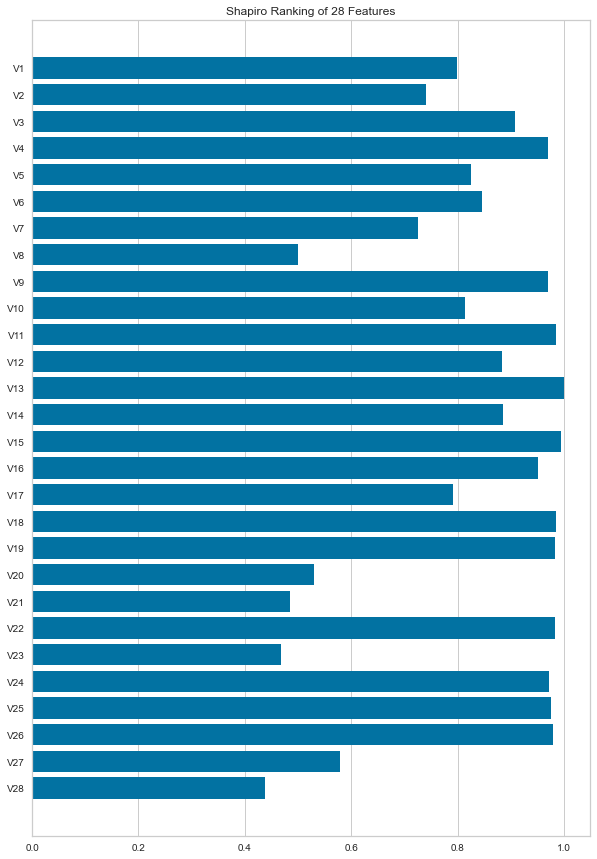

<AxesSubplot:title={'center':'Shapiro Ranking of 28 Features'}>

In [20]:
visualizer = Rank1D(
    algorithm="shapiro",
    features=features,
    size=(720, 1080)
)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

## Are There Outliers?

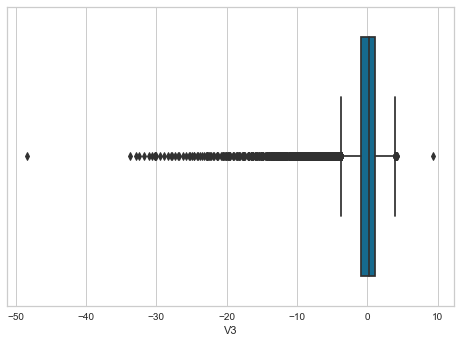

In [21]:
v3_count = sns.boxplot(x=cc_df['V3'])

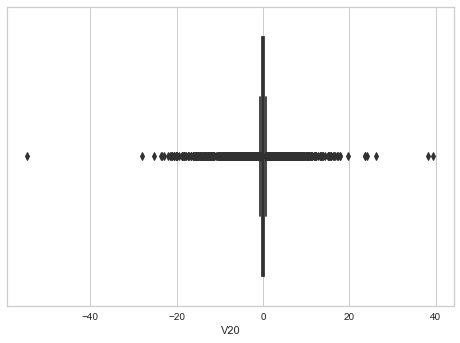

In [22]:
v20_count = sns.boxplot(x=cc_df['V20'])

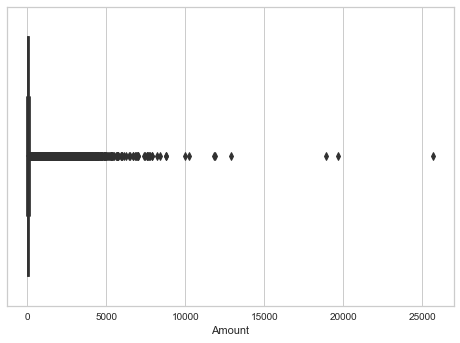

In [23]:
amount_count = sns.boxplot(x=cc_df['Amount'])

What do you notice about the above? How might it impact your feature engineering or model selection process?


## Is there Collinearity?

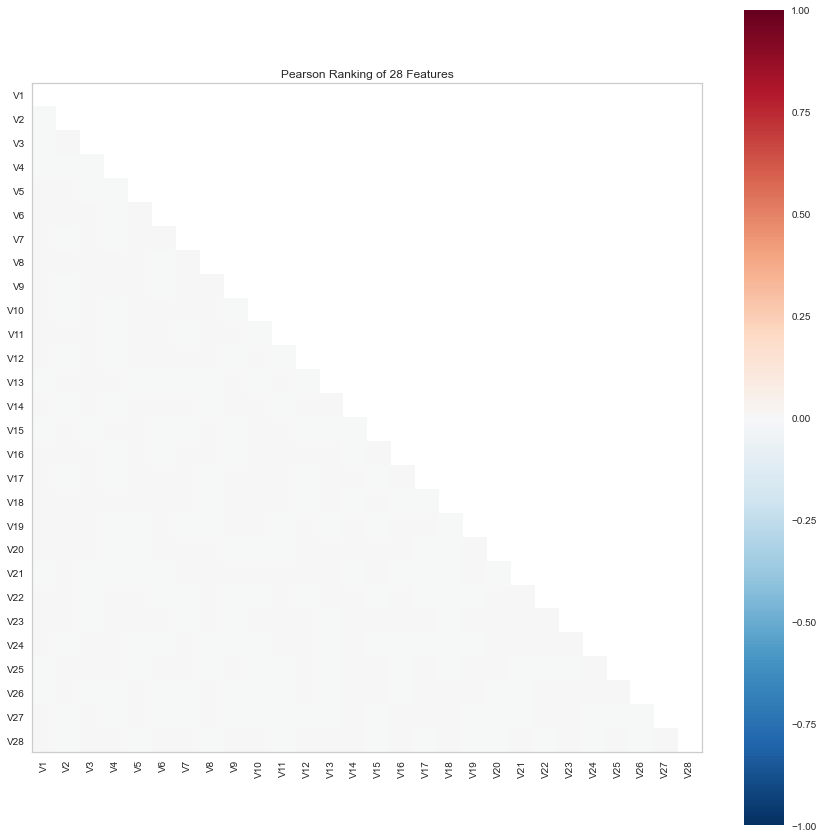

<AxesSubplot:title={'center':'Pearson Ranking of 28 Features'}>

In [24]:
visualizer = Rank2D(
    algorithm="pearson",
    features=features,
    size=(1080, 1080)
)

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.show()

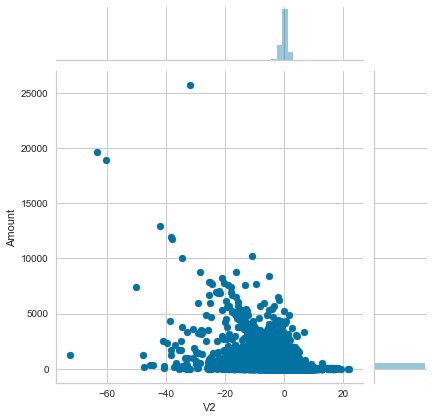

In [25]:
sns.jointplot(data=cc_df, x="V2", y="Amount")

## Is there Correlation?

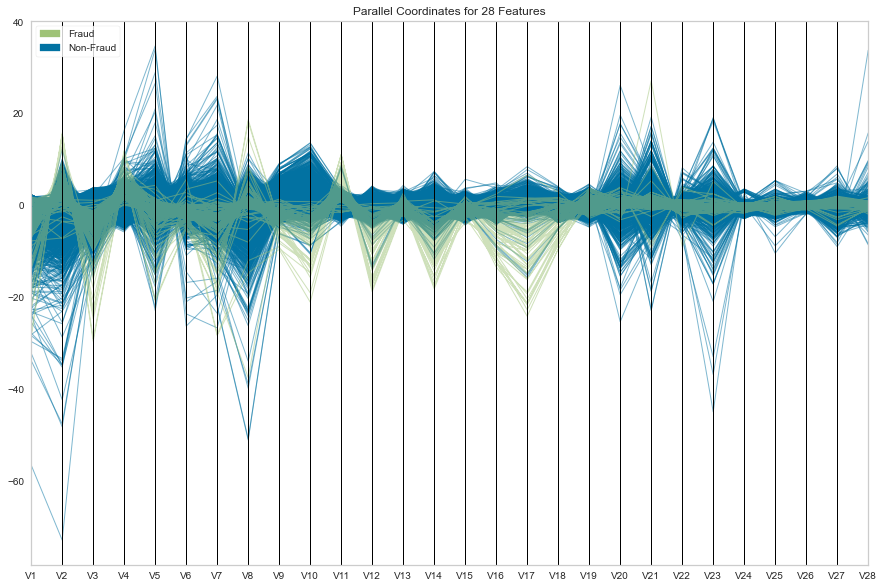

<AxesSubplot:title={'center':'Parallel Coordinates for 28 Features'}>

In [26]:
# Do the features correlate with the target?
mpl.rcParams["agg.path.chunksize"] = 10000
visualizer = ParallelCoordinates(
    classes=classes, 
    features=features,
    size=(1080, 720),
    shuffle=True,
    sample=0.2,
    fast=True
)

visualizer.fit(X, y)
visualizer.transform(y)
visualizer.show()

What do you notice about the above? How might it impact your feature engineering or model selection process?

## Build a Classifier

Your goal is to build a classification model that can predict fraud given input features that describe credit card transaction behavior.